In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
import random
from scipy.interpolate import splrep, BSpline

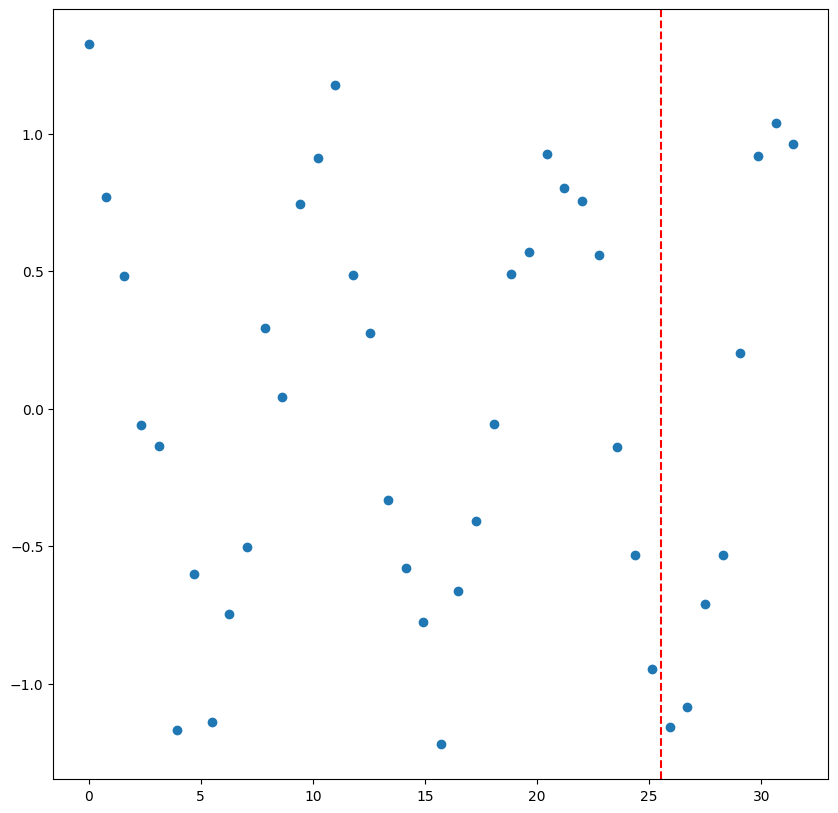

In [40]:
# Suppose we have small experimental data and we want to find counterfactauls of each observation
np.random.seed(1)
x = np.arange(0, 10*np.pi+np.pi/4, 4*np.pi/16)
rng = np.random.default_rng()
y =  np.cos(0.6*x) + 0.2*np.random.normal(size=len(x))
plt.plot(x,y,'o')
plt.axvline(x=np.mean(x[-9:-7]), color='red',linestyle='--')

In [41]:
# divide experimental and pre-experimental data
pre_exp_x = x[:-8]
pre_exp_y = y[:-8]
exp_x = x[-8:]
exp_y = y[-8:]
print(exp_x, exp_y, x, y)

[25.91813939 26.70353756 27.48893572 28.27433388 29.05973205 29.84513021
 30.63052837 31.41592654] [-1.15672947 -1.08530574 -0.7096397  -0.53247906  0.2033176   0.91974569
  1.03941536  0.96163289] [ 0.          0.78539816  1.57079633  2.35619449  3.14159265  3.92699082
  4.71238898  5.49778714  6.28318531  7.06858347  7.85398163  8.6393798
  9.42477796 10.21017612 10.99557429 11.78097245 12.56637061 13.35176878
 14.13716694 14.9225651  15.70796327 16.49336143 17.27875959 18.06415776
 18.84955592 19.63495408 20.42035225 21.20575041 21.99114858 22.77654674
 23.5619449  24.34734307 25.13274123 25.91813939 26.70353756 27.48893572
 28.27433388 29.05973205 29.84513021 30.63052837 31.41592654] [ 1.32486907  0.76865524  0.4821509  -0.05815926 -0.13593547 -1.16741452
 -0.60209416 -1.13992972 -0.74520918 -0.50386457  0.29242159  0.04196236
  0.74453355  0.91087747  1.1778104   0.48712853  0.27453135 -0.33200615
 -0.5793425  -0.77444348 -1.22012384 -0.66206178 -0.40746711 -0.0559356
  0.48918818

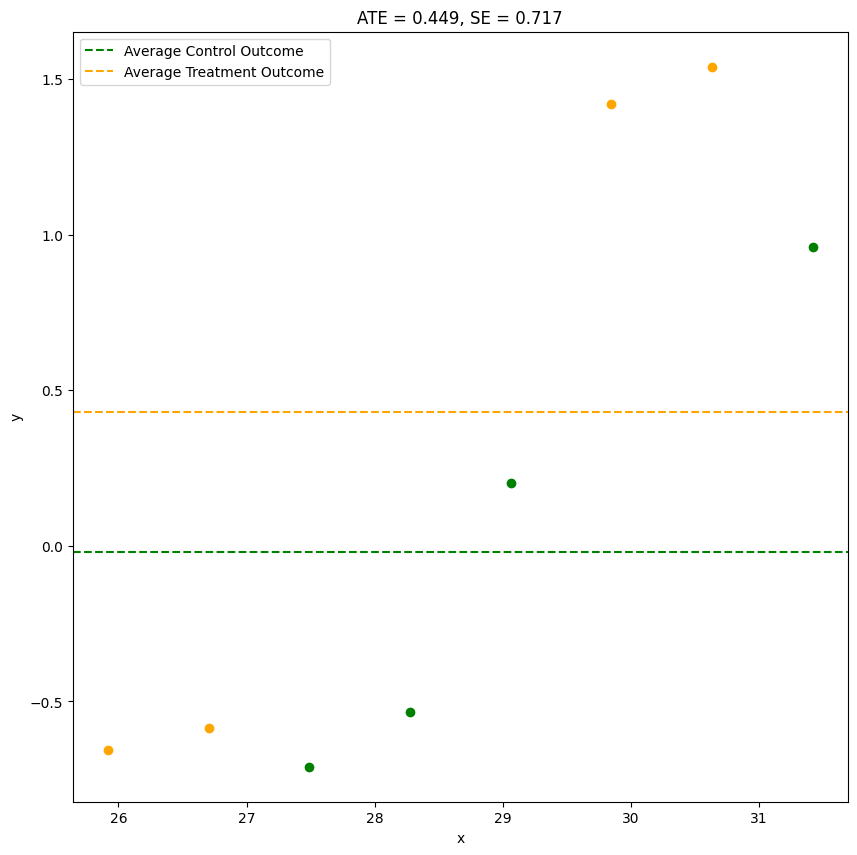

In [79]:
# motivate counterfactual estimation just using experimental data, but poor performance
treat_idx = [0,1,5,6]
control_idx = [2,3,4,7]
te = 0.5
control_x = exp_x[control_idx]
treat_x = exp_x[treat_idx]
control_y = exp_y[control_idx]
treat_y = exp_y[treat_idx] + te
plt.plot(control_x, control_y, 'o',color='green')
plt.plot(treat_x, treat_y, 'o', color='orange')
plt.axhline(y=np.mean(control_y), color='green', linestyle='--', label='Average Control Outcome')
plt.axhline(y=np.mean(treat_y), color='orange', linestyle='--', label='Average Treatment Outcome')
plt.title("ATE = " + str('{0:.3g}'.format(np.mean(treat_y)-np.mean(control_y))) + \
          ", SE = " + str('{0:.3g}'.format((np.var(treat_y, ddof=1)/len(treat_y)+np.var(control_y, ddof=1)/len(control_y))**0.5)))
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

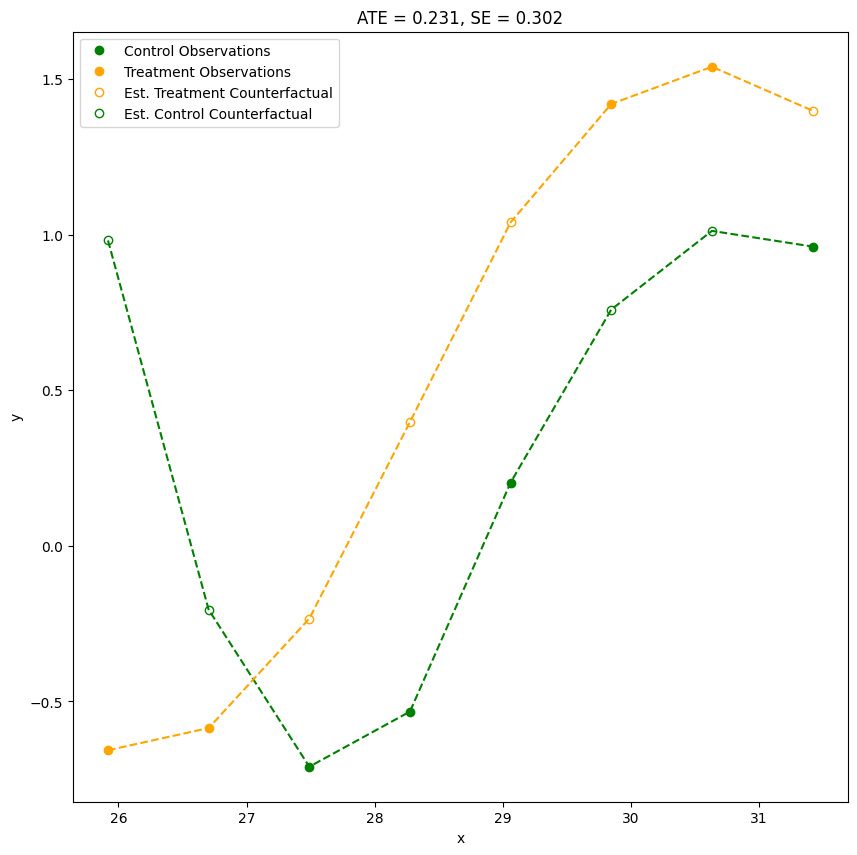

In [81]:
# get better counterfactual by fitting a function to treatment and control outcomes separately
# but this violates constant treatment effect assumption! If treatment is truly constant, then 
# both control and treatment should follow the same function, but only differ by a constant shift
control_sp = splrep(control_x, control_y,k=2)
treat_sp = splrep(treat_x, treat_y,k=2)
plt.plot(control_x, control_y, 'o',color='green',label='Control Observations')
plt.plot(treat_x, treat_y, 'o', color='orange',label='Treatment Observations')
plt.plot(exp_x, BSpline(*control_sp)(exp_x), linestyle='--',color='green')
plt.plot(exp_x, BSpline(*treat_sp)(exp_x), linestyle='--',color='orange')
plt.plot(control_x, BSpline(*treat_sp)(exp_x)[control_idx], 'o',color='orange', 
         fillstyle='none',label='Est. Treatment Counterfactual')
plt.plot(treat_x, BSpline(*control_sp)(exp_x)[treat_idx], 'o',color='green', 
         fillstyle='none',label='Est. Control Counterfactual')
plt.title("ATE = " 
          + str('{0:.3g}'.format(np.mean(BSpline(*treat_sp)(exp_x))
                                 -np.mean(BSpline(*control_sp)(exp_x))))
          + ", SE = " 
          + str('{0:.3g}'.format((np.var(BSpline(*treat_sp)(exp_x)
                                         -BSpline(*control_sp)(exp_x), ddof=1)/len(exp_x))**0.5)))
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Text(0.5, 1.0, 'ATE = 0.449, SE = 0.226')

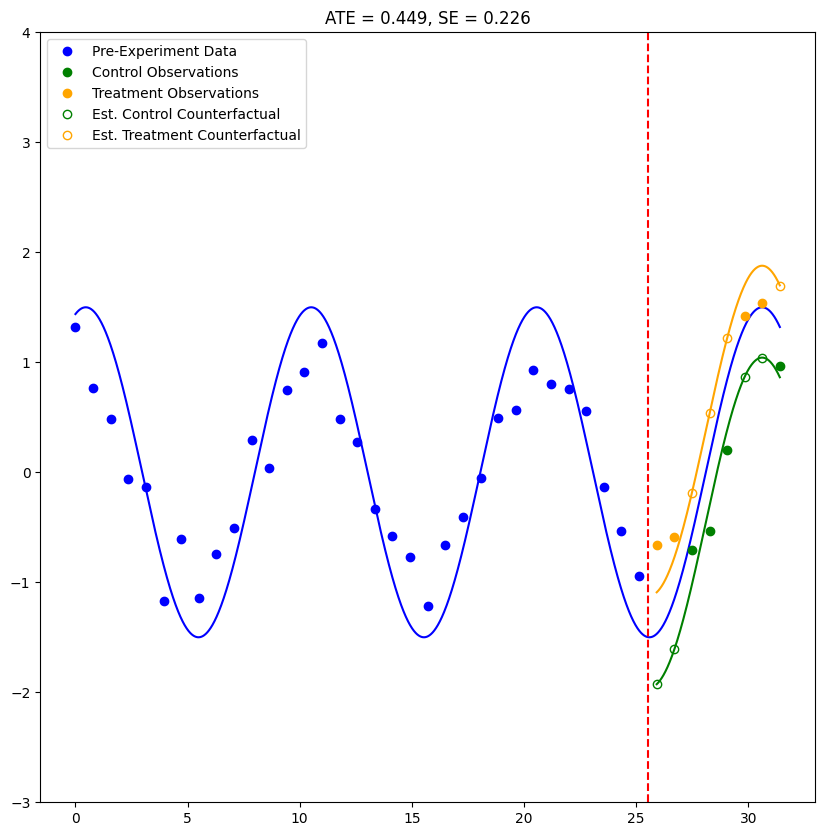

In [99]:
# Too much variability in predictions and violating constant treatment effect assumption
# how can we fit two lines that only differ by a constant shift between control and treatment groups?
# -> use pre-experimental data to make predictions, and bring it to experimental
plt.rcParams["figure.figsize"] = (10,10)
p = len(pre_exp_x)
ax = plt.gca()
ax.set_ylim([-3,4])
ax.plot(pre_exp_x,pre_exp_y,'o', color='blue',label='Pre-Experiment Data')
pre_sp = splrep(pre_exp_x, pre_exp_y, s=3)
#preds = BSpline(*pre_sp)(x)
xnew = np.arange(0,x[-1],0.01)
exp_x_range = np.arange(min(exp_x), max(exp_x), 0.01)
def pred_fun(x):
    return 1.5*np.sin((x-8)/1.6)
ax.plot(xnew,pred_fun(xnew), linestyle='-',color='blue')
ax.plot(control_x, control_y, 'o',color='green',label='Control Observations')
ax.plot(treat_x, treat_y, 'o', color='orange',label='Treatment Observations')
control_shift = np.mean(control_y - pred_fun(control_x))
treat_shift = np.mean(treat_y - pred_fun(treat_x))
ax.plot(exp_x_range, pred_fun(exp_x_range) + control_shift, color='green')
ax.plot(exp_x_range, pred_fun(exp_x_range) + treat_shift, color='orange')
plt.plot(treat_x, pred_fun(treat_x) + control_shift, 'o',color='green', 
         fillstyle='none',label='Est. Control Counterfactual')
plt.plot(control_x, pred_fun(control_x) + treat_shift, 'o',color='orange', 
         fillstyle='none',label='Est. Treatment Counterfactual')
ax.axvline(x=np.mean(x[-9:-7]), color='red',linestyle='--')
ax.legend()
ATE = sum(treat_y - (pred_fun(control_x) + control_shift))/8 \
    +sum(pred_fun(treat_x) + treat_shift - control_y)/8
SE = (np.var(treat_y - pred_fun(treat_x) - treat_shift, ddof=1)/len(treat_y)
     + np.var(control_y - pred_fun(control_x) - control_shift, ddof=1)/len(control_y))**0.5
ax.set_title("ATE = "+ str('{0:.3g}'.format(ATE)) + ", SE = " + str('{0:.3g}'.format(SE)))

In [70]:
# With sufficient pre-experimental data, trend/seasonality can be identified 
# and extrapolated reliably to experimental data
# but what if there isnt sufficient pre-experimental data? 

(33, array([2, 3, 4, 7]))

In [27]:
# linear adjustment? make adjustments to the prediction to fit the experimental data better
# more variability in model, but hopefully give more realistic counterfactuals
# intercept already determined by shifts,
# determine common slope/scale/rotation factor by fitting a linear regression in terms of x
# outcome are the residuals (difference between observed and predicted outcome)
treat_resid = treat_y - (preds[p+np.array(treat_idx)] + treat_shift)
control_resid = control_y - (preds[p+np.array(control_idx)] + control_shift)
resid = np.concatenate([treat_resid, control_resid])
x_reordered = np.concatenate([p+np.array(treat_idx), p+np.array(control_idx)])
model = sm.OLS(resid, x_reordered)
res = model.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.000
Model:                            OLS   Adj. R-squared (uncentered):             -0.142
Method:                 Least Squares   F-statistic:                           0.002697
Date:                Fri, 19 Jan 2024   Prob (F-statistic):                       0.960
Time:                        15:58:50   Log-Likelihood:                         -6.0432
No. Observations:                   8   AIC:                                      14.09
Df Residuals:                       7   BIC:                                      14.17
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

C:\Users\alexk\anaconda3\envs\abtest\Lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [11]:
pred_ols = res.get_prediction()
pred_ols['mean']
adjusted_preds = 

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,0.385453,0.275887,-0.266915,1.037822,-1.703761,2.474668
1,0.419464,0.300230,-0.290466,1.129394,-1.688434,2.527362
2,0.430801,0.308344,-0.298316,1.159918,-1.683636,2.545238
3,0.442138,0.316458,-0.306167,1.190442,-1.678992,2.563268
4,0.374117,0.267772,-0.259064,1.007297,-1.709186,2.457419
5,0.396790,0.284001,-0.274765,1.068346,-1.698494,2.492075
6,0.408127,0.292115,-0.282616,1.098870,-1.693386,2.509640
7,0.453475,0.324572,-0.314017,1.220967,-1.674500,2.581449
